In [1]:
!python --version

Python 3.7.16


In [1]:
from Agent import Agent
#from NegotiationNet import NegotiationNet

import torch

import numpy as np
import pandas as pd

import os
os.chdir("..")
from rice import Rice

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# envs_2_regions = [Rice(region_yamls_filename='2_region_yamls/') for _ in range(5)]
# initial_state_2 = envs_2_regions[0].reset()

# envs_4_regions = [Rice(region_yamls_filename='identical_region_yamls/') for _ in range(5)]
# initial_state_4 = envs_4_regions[0].reset()

In [3]:
# agents_2 = [Agent(envs_2_regions[0], initial_state_2[agent_id], agent_id) 
#             for agent_id in range(envs_2_regions[0].num_agents)]
# agents_4 = [Agent(envs_4_regions[0], initial_state_4[agent_id], agent_id) 
#             for agent_id in range(envs_4_regions[0].num_agents)]

In [2]:
envs = [Rice(region_yamls_filename='2_region_yamls/', num_discrete_action_levels=5) for _ in range(5)]
initial_state = envs[0].reset()
agents = [Agent(envs[0], initial_state[agent_id], agent_id) 
            for agent_id in range(envs[0].num_agents)]

In [3]:
def negotiate_proposals(agents, envs, states):
    collective_action = {}
    for agent in agents:
        collective_action[agent.id] = agent.negotiate(
            [state[agent.id] for state in states],
            save_map = {
                'save_state' : True,
                'save_decisions' : False,
                'save_proposals_promises' : True
            }
        )
        
    for env_id in range(len(envs)):
        envs[env_id].register_proposals({
            agent_id: {
                identifier: action[env_id]
                for identifier, action in action_dict.items()
            }
            for agent_id, action_dict in collective_action.items()
        })
        

In [4]:
def negotiate_decisions(agents, envs, states):
    collective_action = {}
    for agent in agents:
        collective_action[agent.id] = agent.negotiate(
            [state[agent.id] for state in states],
            save_map = {
                'save_state' : False,
                'save_decisions' : True,
                'save_proposals_promises' : False
            }
        )
        
    for env_id in range(len(envs)):
        envs[env_id].register_decisions({
            agent_id: {
                identifier: action[env_id]
                for identifier, action in action_dict.items()
            }
            for agent_id, action_dict in collective_action.items()
        })

In [5]:
def act_collectively(agents, envs, states, with_mask = True):
    collective_action = {}
    for agent in agents:
        collective_action[agent.id] = agent.act(
            [state[agent.id] for state in states],
            with_mask = with_mask
        )
    
    states, rewards, _, _ = zip(*[
        env.step({agent_id : collective_action[agent_id][i] 
                for agent_id in range(len(agents))}) 
        for (i, env) in enumerate(envs)
    ])
    return states, rewards

In [6]:
def register_rewards(agents, rewards_negotiation, rewards_no_negotiation, is_terminal):
    for agent in agents:
        
        agent.nets['negotiationNet'].buffer.rewards.extend([reward[agent.id] for reward in rewards_no_negotiation])
        agent.nets['negotiationNet'].buffer.is_terminals.extend([is_terminal] * len(envs))

        agent.nets['activityNet'].buffer.rewards.extend([reward[agent.id] for reward in rewards_negotiation])
        agent.nets['activityNet'].buffer.is_terminals.extend([is_terminal] * len(envs))

In [7]:
# rs_difference = {agent.id : [] for agent in agents}
rs_negotiation = {agent.id : [] for agent in agents}

episode_length = envs[0].episode_length

for epoch in tqdm(range(10)):
    
    for batch in range(20):
        states = [env.reset() for env in envs]
        for t in range(envs[0].episode_length):
            
            negotiate_proposals(agents, envs, states)
            negotiate_decisions(agents, envs, states)
            
            # Update action masks from negotiation
            for env in envs:
                env.update_masks()
       
            #states, rewards_no_negotiation = act_collectively(agents, envs, states, with_mask=False)
            #states = [env.rollback() for env in envs]
            states, rewards_negotiation = act_collectively(agents, envs, states)
            
            # Rewards with negotiation - rewards without negotiation
#             for (env_id, d) in enumerate(rewards_negotiation):
#                 for agent_id in d:
#                     rewards_no_negotiation[env_id][agent_id] = \
#                         rewards_negotiation[env_id][agent_id] - \
#                         rewards_no_negotiation[env_id][agent_id]
            for (agent_id, mean_reward) in enumerate(np.mean([list(r.values()) for r in rewards_negotiation], axis = 0)):
                rs_negotiation[agent_id].append(mean_reward)
                
#             for (agent_id, mean_reward) in enumerate(np.mean([list(r.values()) for r in rewards_no_negotiation], axis = 0)):
#                 rs_difference[agent_id].append(mean_reward)
                
            
            register_rewards(agents, rewards_negotiation, rewards_negotiation, t == episode_length)
    for agent in agents:
        agent.update()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.77s/it]


<Axes: >

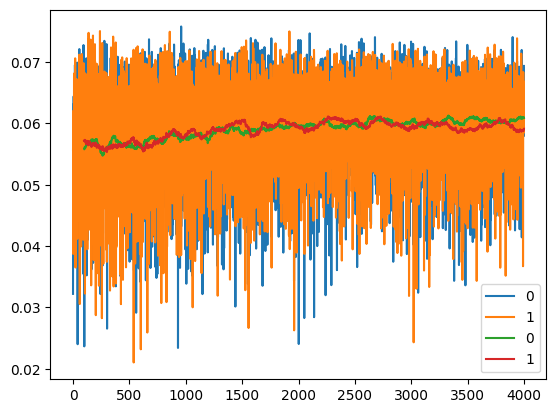

In [8]:
all_rewards = pd.DataFrame(rs_negotiation)
df = pd.concat((all_rewards, all_rewards.rolling(window = 100).mean()), axis = 1)
df.plot()

In [11]:
s = envs[0].reset()[0]
agents[0].eval_act(s)

RuntimeError: shape '[43, 7, -1]' is invalid for input of size 35

In [11]:
rss_diff = {k: np.array(rs_difference[k]) for k in rs_difference}
rss_nego = {k: np.array(rs_negotiation[k]) for k in rs_negotiation}

In [16]:
# Cell without any negotiation

envs = [Rice(region_yamls_filename='2_region_yamls/') for _ in range(5)]
initial_state = envs[0].reset()
agents = [Agent(envs[0], initial_state[agent_id], agent_id) 
            for agent_id in range(envs[0].num_agents)]

rs = {agent.id : [] for agent in agents}

episode_length = envs[0].episode_length

for epoch in tqdm(range(50)):
    for batch in range(20):
        states = [env.reset() for env in envs]
        for t in range(envs[0].episode_length):
            
            states, rewards = act_collectively(agents, envs, states)
            
            # Register rewards into agents' buffers
            for agent in agents:
                r = [reward[agent.id] for reward in rewards]
                rs[agent.id].append(r)
                
                agent.nets['activityNet'].buffer.rewards.extend(r)
                agent.nets['activityNet'].buffer.is_terminals.extend([t == episode_length - 1] * len(envs))
                
    for agent in agents:
        agent.nets['activityNet'].update()

100%|███████████████████████████████████████████| 50/50 [02:58<00:00,  3.57s/it]


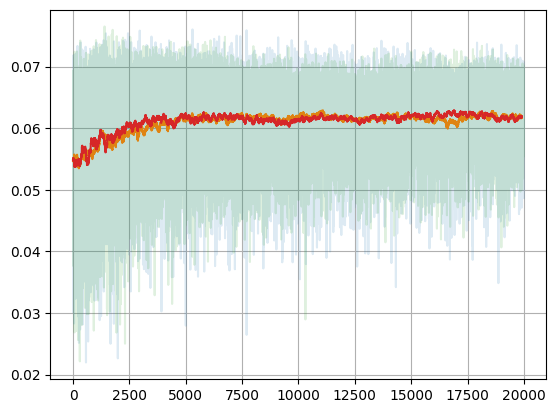

In [24]:
#rs = {k: np.array(rs[k]).mean(axis=1) for k in rs}
for r in rs:
    plt.plot(rs[r], alpha = .15)
    plt.plot(np.convolve(rs[r], np.ones(100)/100, mode = 'valid'))
plt.grid()
plt.show()

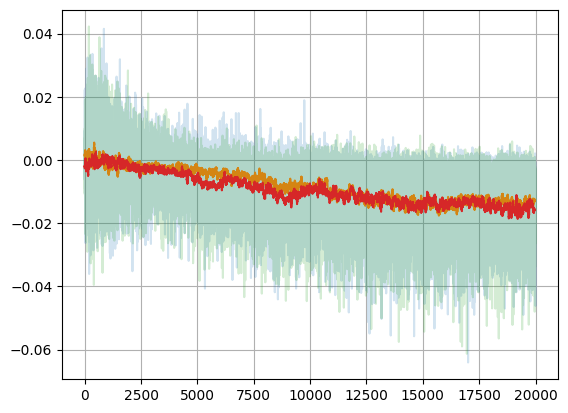

In [12]:
for r in rss_diff:
    plt.plot(rss_diff[r], alpha = .2)
    plt.plot(np.convolve(rss_diff[r], np.ones(50)/50, mode='valid'))

plt.grid()
plt.show()

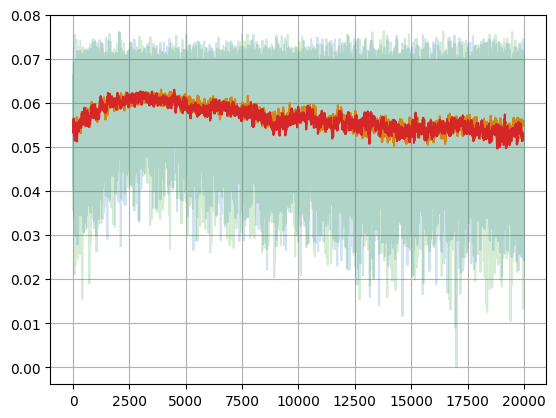

In [13]:
for r in rss_nego:
    plt.plot(rss_nego[r], alpha = .2)
    plt.plot(np.convolve(rss_nego[r], np.ones(50)/50, mode='valid'))

plt.grid()
plt.show()